In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Feature Importance Analysis

In [10]:
def k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, sorted_feature_names): 
    regression_coefficients = []
    p_values = []
    rsf_weights = []
    for i in range(5):
        ### CPH feature importance
        fold_cph_file = "split" + str(i) + "/results/" + cph_file_name
        cph_table = pd.read_html(fold_cph_file)
        assert len(cph_table) == 1
        fold_cph_df = cph_table[0]
        fold_cph_df.rename(columns={"Unnamed: 0":"Feature"}, inplace=True)

        # Check that the feature order is the same for all folds
        fold_cph_df.sort_values(by=["Feature"], inplace = True)
        assert list(fold_cph_df["Feature"]) == sorted_feature_names

        regression_coefficients.append(fold_cph_df["coef"].to_numpy())
        p_values.append(fold_cph_df["p"].to_numpy())

        ### RSF feature importance
        fold_rsf_file = "split" + str(i) + "/results/" + rsf_file_name
        rsf_table = pd.read_html(fold_rsf_file)
        assert len(rsf_table) == 1
        fold_rsf_df = rsf_table[0]

        # Check that the feature order is the same for all folds
        fold_rsf_df.sort_values(by=["Feature"], inplace = True)
        assert list(fold_rsf_df["Feature"]) == sorted_feature_names

        fold_rsf_df[["Weight Avg", "Weight Std"]] = fold_rsf_df["Weight"].str.split("±", expand=True).astype("float")
        rsf_weights.append(fold_rsf_df["Weight Avg"])

    regression_coefficients = np.stack(regression_coefficients, axis=0)
    avg_coef = np.mean(regression_coefficients, axis=0)
    std_coef = np.std(regression_coefficients, axis=0)
    str_regression_coefficients = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_coef, std_coef)]

    p_values = np.stack(p_values, axis=0)
    avg_p = np.mean(p_values, axis = 0)
    std_p = np.std(p_values, axis = 0)
    str_p_values = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_p, std_p)]

    rsf_weights = np.stack(rsf_weights, axis=0)
    rsf_weight_avg_across_folds = np.mean(rsf_weights, axis=0)
    rsf_weight_std_across_folds = np.std(rsf_weights, axis=0)
    str_rsf_weights = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(rsf_weight_avg_across_folds, rsf_weight_std_across_folds)]

    k_fold_df = pd.DataFrame(data={"Feature": sorted_feature_names, "CPH coefficient": str_regression_coefficients, "CPH p-value": str_p_values, "RSF Importance Weight": str_rsf_weights})
    
    return k_fold_df, avg_coef, std_coef, avg_p, std_p, rsf_weight_avg_across_folds, rsf_weight_std_across_folds

## Clinical

In [11]:
clin_feature_names = [
        'Age',
        'BMI',
        'Pack-year',
        'Smoking-start-age',
        'Cigarettes-per-day',
        'Number-of-smoking-years',
        'High-school-graduate',
        'Post-HS-training',
        'Associate-degree',
        'Bachelors-degree',
        'Graduate-school',
        'Female',
        'Non-white',
        'Smoking-at-the-start-of-trial',
        'Lived-with-smoker',
        'Worked-with-smoker',
        'Cancer-prior-to-trial',
        'Family-member-had-cancer']

clin_feature_names.sort()

In [12]:
cph_table = pd.read_html("split4/results/cph_clinical_all.html")

In [14]:
cph_file_name = "cph_clinical_all.html"
rsf_file_name = "rsf_clinical_all.html"

clinical_df, avg_coef, std_coef, avg_p, std_p, avg_rsf_weight, std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, clin_feature_names)
display(clinical_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,Age,-0.028 ± 0.037,0.853 ± 0.205,0.061 ± 0.017
1,Associate-degree,0.096 ± 0.141,0.794 ± 0.285,0.013 ± 0.006
2,BMI,0.028 ± 0.034,0.833 ± 0.204,0.094 ± 0.013
3,Bachelors-degree,-0.082 ± 0.161,0.868 ± 0.256,0.008 ± 0.006
4,Cancer-prior-to-trial,0.436 ± 0.283,0.350 ± 0.247,0.017 ± 0.010
5,Cigarettes-per-day,-0.001 ± 0.006,0.989 ± 0.013,0.035 ± 0.011
6,Family-member-had-cancer,0.108 ± 0.140,0.733 ± 0.327,0.016 ± 0.011
7,Female,-0.259 ± 0.229,0.446 ± 0.359,0.020 ± 0.004
8,Graduate-school,-0.100 ± 0.170,0.844 ± 0.248,0.003 ± 0.002
9,High-school-graduate,0.047 ± 0.082,0.882 ± 0.202,0.012 ± 0.005


In [71]:
def plot_metrics(mean_array, std_array, feature_names, ylabel, title, ax):
    sorted_idx = np.argsort(mean_array)

    feature_index = np.arange(len(feature_names))
    ax.bar(feature_index, mean_array[sorted_idx], yerr=std_array[sorted_idx], align='center', capsize=5)
    ax.set_xticks(feature_index)
    ax.set_xticklabels([feature_names[i] for i in sorted_idx], rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y')
#     ax.rc('font', {'name': 'times'})

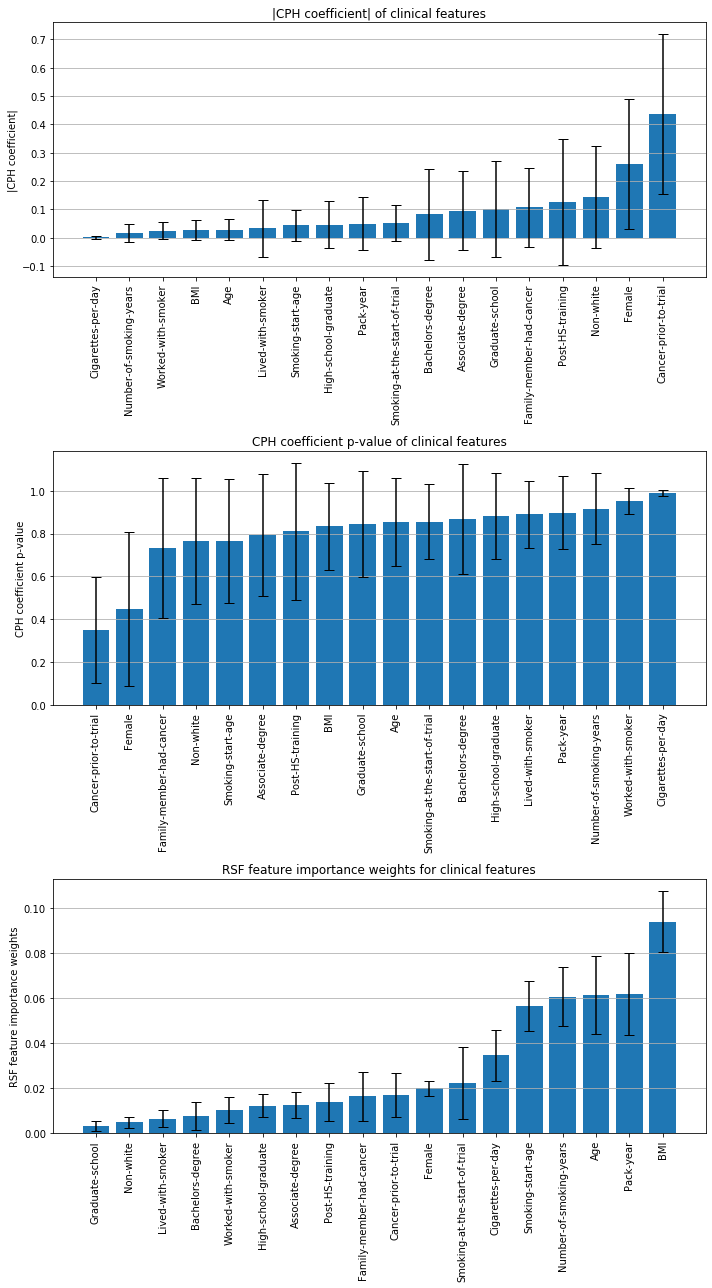

In [119]:
fig, axes = plt.subplots(3, 1, figsize=(10,18))

plot_metrics(np.absolute(avg_coef), std_coef, clin_feature_names, '|CPH coefficient|','|CPH coefficient| of clinical features', axes[0])
plot_metrics(avg_p, std_p, clin_feature_names, 'CPH coefficient p-value','CPH coefficient p-value of clinical features', axes[1])
plot_metrics(avg_rsf_weight, std_rsf_weight, clin_feature_names, 'RSF feature importance weights','RSF feature importance weights for clinical features', axes[2])

fig.tight_layout()

## Radiomics 1

In [73]:
radiomics1_feature_names = ['original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume']
radiomics1_feature_names.sort()

In [74]:
cph_file_name = "cph_radiomics1_all.html"
rsf_file_name = "rsf_radiomics1_all.html"

radiomics1_df, rad1_avg_coef, rad1_std_coef, rad1_avg_p, rad1_std_p, rad1_avg_rsf_weight, rad1_std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, radiomics1_feature_names)
display(radiomics1_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,original_shape_Elongation,-0.162 ± 0.102,0.434 ± 0.294,0.017 ± 0.006
1,original_shape_Flatness,0.100 ± 0.109,0.668 ± 0.289,0.024 ± 0.015
2,original_shape_LeastAxisLength,0.000 ± 0.106,0.766 ± 0.158,0.019 ± 0.013
3,original_shape_MajorAxisLength,0.034 ± 0.049,0.872 ± 0.084,0.029 ± 0.015
4,original_shape_Maximum2DDiameterColumn,0.280 ± 0.153,0.322 ± 0.172,0.021 ± 0.020
5,original_shape_Maximum2DDiameterRow,0.144 ± 0.097,0.610 ± 0.155,0.021 ± 0.025
6,original_shape_Maximum2DDiameterSlice,-0.098 ± 0.091,0.755 ± 0.188,0.016 ± 0.025
7,original_shape_Maximum3DDiameter,0.116 ± 0.112,0.678 ± 0.176,0.018 ± 0.030
8,original_shape_MinorAxisLength,0.029 ± 0.056,0.932 ± 0.065,0.019 ± 0.014
9,original_shape_Sphericity,0.140 ± 0.106,0.451 ± 0.342,0.048 ± 0.025


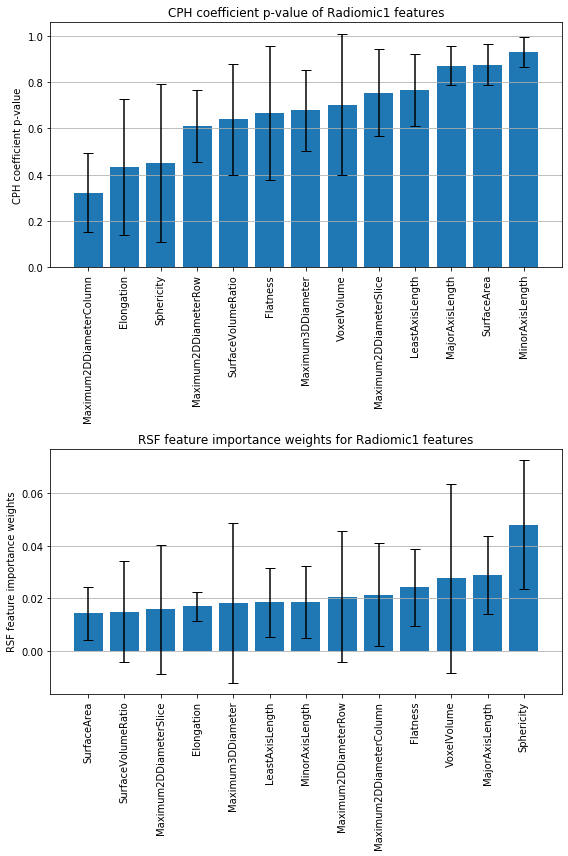

In [77]:
rad1_feature_names_cleaned = [name.replace('original_shape_', '') for name in radiomics1_feature_names]
fig, axes = plt.subplots(2, 1, figsize=(8,12))

plot_metrics(rad1_avg_p, rad1_std_p, rad1_feature_names_cleaned, 'CPH coefficient p-value','CPH coefficient p-value of Radiomic1 features', axes[0])
plot_metrics(rad1_avg_rsf_weight, rad1_std_rsf_weight, rad1_feature_names_cleaned, 'RSF feature importance weights','RSF feature importance weights for Radiomic1 features', axes[1])

fig.tight_layout()

## Radiomics 2

In [79]:
radiomics2_feature_names = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance']
radiomics2_feature_names.sort()

In [82]:
cph_file_name = "cph_radiomics2_all.html"
rsf_file_name = "rsf_radiomics2_all.html"

radiomics2_df, rad2_avg_coef, rad2_std_coef, rad2_avg_p, rad2_std_p, rad2_avg_rsf_weight, rad2_std_rsf_weight = k_fold_feature_importance_metrics(cph_file_name, rsf_file_name, radiomics2_feature_names)
display(radiomics2_df)

,Feature,CPH coefficient,CPH p-value,RSF Importance Weight
0,original_firstorder_10Percentile,0.004 ± 0.005,0.928 ± 0.090,0.018 ± 0.010
1,original_firstorder_90Percentile,0.016 ± 0.011,0.832 ± 0.130,0.009 ± 0.008
2,original_firstorder_Energy,0.110 ± 0.077,0.360 ± 0.230,0.018 ± 0.004
3,original_firstorder_Entropy,-0.002 ± 0.004,0.970 ± 0.050,0.011 ± 0.006
4,original_firstorder_InterquartileRange,0.001 ± 0.001,0.989 ± 0.014,0.018 ± 0.023
5,original_firstorder_Kurtosis,-0.018 ± 0.027,0.841 ± 0.184,0.018 ± 0.004
6,original_firstorder_Maximum,0.005 ± 0.008,0.916 ± 0.109,0.027 ± 0.007
7,original_firstorder_Median,0.099 ± 0.071,0.526 ± 0.150,0.023 ± 0.009
8,original_firstorder_Minimum,0.010 ± 0.013,0.907 ± 0.093,0.014 ± 0.016
9,original_firstorder_RootMeanSquared,-0.055 ± 0.030,0.682 ± 0.046,0.017 ± 0.019


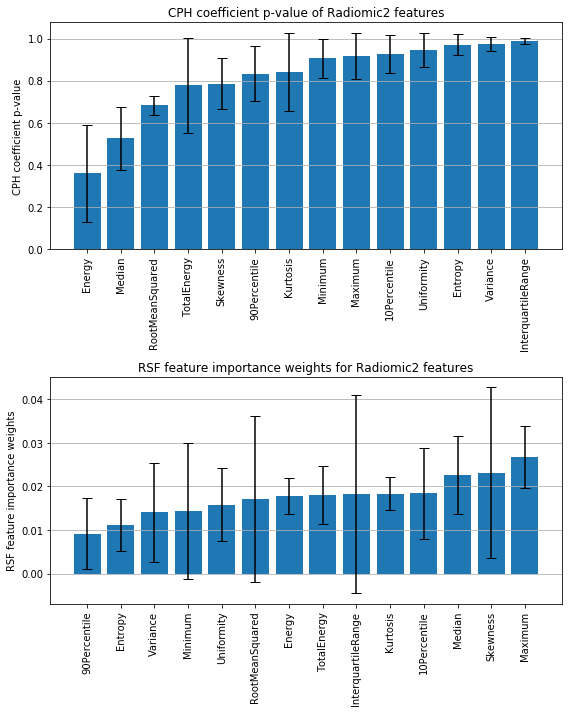

In [86]:
rad2_feature_names_cleaned = [name.replace('original_firstorder_', '') for name in radiomics2_feature_names]
fig, axes = plt.subplots(2, 1, figsize=(8,10))

plot_metrics(rad2_avg_p, rad2_std_p, rad2_feature_names_cleaned, 'CPH coefficient p-value','CPH coefficient p-value of Radiomic2 features', axes[0])
plot_metrics(rad2_avg_rsf_weight, rad2_std_rsf_weight, rad2_feature_names_cleaned, 'RSF feature importance weights','RSF feature importance weights for Radiomic2 features', axes[1])

fig.tight_layout()

# Average C-index and MTD-AUC

In [116]:
c_index_by_fold = []
mtd_auc_by_fold = []
for i in range(5):
    result_file = "split" + str(i) + "/results.txt"
    results_df = pd.read_csv(result_file, sep='\t', header=None, names=["Experiment name", "C-index", "MTD-AUC"])
    
    c_index_by_fold.append(results_df["C-index"].to_numpy())
    mtd_auc_by_fold.append(results_df["MTD-AUC"].to_numpy())
    
c_index = np.stack(c_index_by_fold, axis=0)
avg_c_index = np.mean(c_index, axis=0)
std_c_index = np.std(c_index, axis=0)
str_c_index = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_c_index, std_c_index)]

mtd_auc = np.stack(mtd_auc_by_fold, axis=0)
avg_mtd_auc = np.mean(mtd_auc, axis=0)
std_mtd_auc = np.std(mtd_auc, axis=0)
str_mtd_auc = ["{:.3f} ± {:.3f}".format(mean, std) for (mean, std) in zip(avg_mtd_auc, std_mtd_auc)]

k_fold_results_df = pd.DataFrame(data={"Experiment name": results_df["Experiment name"].to_numpy(), "C-index": str_c_index, "MTD-AUC": str_mtd_auc})
k_fold_results_df[["Model", "Data", "Subset"]] = k_fold_results_df["Experiment name"].str.split("-", expand=True)
k_fold_results_df.drop(columns='Subset', inplace=True)
k_fold_results_df.replace("CPH_lifelines", "CPH", inplace=True)
display(k_fold_results_df)

,Experiment name,C-index,MTD-AUC,Model,Data
0,CPH_lifelines-clinical-all,43.204 ± 7.143,43.014 ± 9.570,CPH,clinical
1,RSF-clinical-all,45.538 ± 6.839,47.800 ± 11.402,RSF,clinical
2,CPH_lifelines-radiomics1-all,59.166 ± 5.356,64.434 ± 7.242,CPH,radiomics1
3,RSF-radiomics1-all,61.552 ± 3.514,66.726 ± 5.899,RSF,radiomics1
4,CPH_lifelines-radiomics2-all,61.698 ± 8.631,65.828 ± 9.515,CPH,radiomics2
5,RSF-radiomics2-all,50.206 ± 6.134,53.656 ± 7.846,RSF,radiomics2
6,CPH_lifelines-radiomics3-all,60.644 ± 8.866,64.140 ± 9.857,CPH,radiomics3
7,RSF-radiomics3-all,51.840 ± 5.746,59.230 ± 7.770,RSF,radiomics3


# TD-AUC Curve

In [ ]:
cpc_auc_file = "clinical_all_cpc_auc.npy"
rsf_auc_file = "clinical_all_rsf_auc.npy"
va_times = "clinical_all_va_times.npy"

cpc_auc_by_split = []
rsf_auc_by_split = []
for i in range(2):
    cpc_auc_by_split.append(np.load("split" + str(i) + "/" + cpc_auc_file))
    rsf_auc_by_split.append(np.load("split" + str(i) + "/" + rsf_auc_file))
    
cpc_auc_matrix = np.stack(cpc_auc_by_split, axis=1)
rsf_auc_matrix = np.stack(rsf_auc_by_split, axis=1)